In [1]:
import csv
import re
import pickle
import random

import numpy as np
import pandas as pd

from sklearn import metrics

from keras.utils.np_utils import to_categorical

from recordlinker.preprocess import embed
from recordlinker.blocking import BinaryEncoder
from recordlinker.metrics import normalized_l1

from pyjarowinkler import distance

import matplotlib.pyplot as plt
% matplotlib inline

import warnings

warnings.filterwarnings('ignore')


Using TensorFlow backend.


In [2]:
%reload_ext autoreload
%autoreload 2

# Table of Contents

### Data import and creating matches / nonmatches datasets 
 - Iowa Census (1915 and 1940) 
 - Union Army
 
#### Jaro-Winkler
#### Autoencoder

# Data

### Iowa 
Names from Iowa census linked between 1915 and 1940. 

In [3]:
iowa_matches = pd.read_csv(
    '/Users/kailinlu/Desktop/QMSSWork/RecordLinking/recordlinker/recordlinker/data/iowa_matches.csv')
iowa_nonmatches = pd.read_csv(
    '/Users/kailinlu/Desktop/QMSSWork/RecordLinking/recordlinker/recordlinker/data/iowa_nonmatches.csv')


In [4]:
iowa_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Data columns (total 11 columns):
uid1915         4320 non-null object
fname1915       4320 non-null object
lname1915       4320 non-null object
fullname1915    4320 non-null object
yob1915         4320 non-null int64
hhid            4320 non-null int64
fname1940       4320 non-null object
lname1940       4320 non-null object
fullname1940    4320 non-null object
yob1940         4320 non-null int64
uid-hhid        4320 non-null object
dtypes: int64(3), object(8)
memory usage: 371.3+ KB


### Union Army 

In [5]:
union_matches = pd.read_csv('/Users/kailinlu/Desktop/QMSSWork/RecordLinking/recordlinker/recordlinker/data/unionarmy_matches.csv')
union_nonmatches = pd.read_csv('/Users/kailinlu/Desktop/QMSSWork/RecordLinking/recordlinker/recordlinker/data/unionarmy_nonmatches.csv')

In [6]:
union_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44098 entries, 0 to 44097
Data columns (total 7 columns):
recidnum    44098 non-null int64
recname1    44098 non-null object
recname2    44098 non-null object
last1       44098 non-null object
first1      44098 non-null object
last2       44098 non-null object
first2      44098 non-null object
dtypes: int64(1), object(6)
memory usage: 2.4+ MB


In [7]:
iowa_matches['match'] = 1
union_matches['match'] = 1

iowa_nonmatches['match'] = 0
union_nonmatches['match'] = 0

# Concatenate into one dataset for Iowa and one for Union Army 
iowa = pd.concat([iowa_matches, iowa_nonmatches])
union = pd.concat([union_matches, union_nonmatches])

# Distance Baseline: Jaro-Winkler

In [8]:
def hist_overlap(a, b, bins=20):
    n,b,p = plt.hist(a, bins=bins)
    nn,nb,npatches = plt.hist(b, bins=bins)
    
    n = n/len(a)
    nn = nn/len(b)

    overlap = 0 
    for i, e in enumerate(n): 
        overlap += min(e, nn[i])  
    return overlap

In [9]:
iowa['last-jaro-winkler'] = iowa.apply(lambda row: distance.get_jaro_distance(row.lname1915, row.lname1940), axis=1)
iowa['first-jaro-winkler'] = iowa.apply(lambda row: distance.get_jaro_distance(row.fname1915, row.fname1940), axis=1)
iowa['full-jaro-winkler'] = iowa.apply(lambda row: distance.get_jaro_distance(row.fullname1915, row.fullname1940), axis=1)

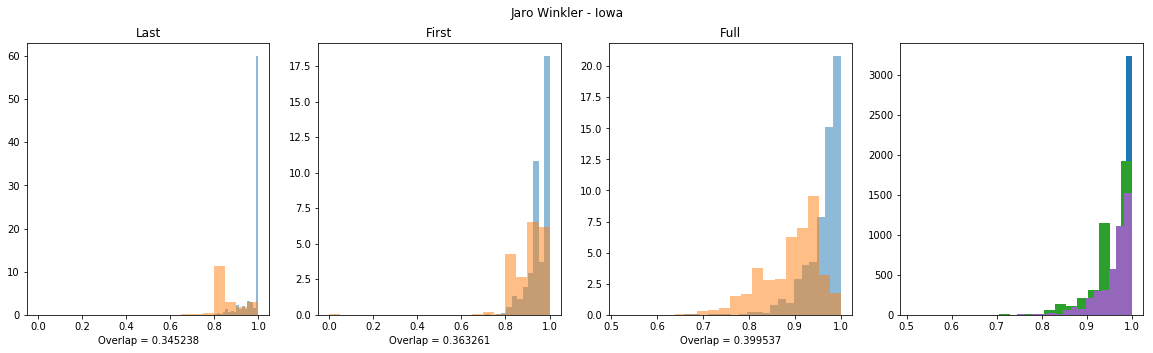

In [10]:
fig, axes = plt.subplots(1,4, figsize=(20,5))
fig.suptitle('Jaro Winkler - Iowa')
axes[0].hist(iowa[iowa['match']==1]['last-jaro-winkler'], alpha=.5, normed=True, bins=20)
axes[0].hist(iowa[iowa['match']==0]['last-jaro-winkler'], alpha=.5, normed=True, bins=20)
axes[0].set_title('Last')
axes[0].set_xlabel('Overlap = {:2f}'.format(hist_overlap(iowa[iowa['match']==1]['last-jaro-winkler'], 
                                                      iowa[iowa['match']==0]['last-jaro-winkler'])))

axes[1].hist(iowa[iowa['match']==1]['first-jaro-winkler'], alpha=.5, normed=True, bins=20)
axes[1].hist(iowa[iowa['match']==0]['first-jaro-winkler'], alpha=.5, normed=True, bins=20)
axes[1].set_title('First')
axes[1].set_xlabel('Overlap = {:2f}'.format(hist_overlap(iowa[iowa['match']==1]['first-jaro-winkler'], 
                                                      iowa[iowa['match']==0]['first-jaro-winkler'])))

axes[2].hist(iowa[iowa['match']==1]['full-jaro-winkler'], alpha=.5, normed=True, bins=20)
axes[2].hist(iowa[iowa['match']==0]['full-jaro-winkler'], alpha=.5, normed=True, bins=20)
axes[2].set_title('Full')
axes[2].set_xlabel('Overlap = {:2f}'.format(hist_overlap(iowa[iowa['match']==1]['full-jaro-winkler'], 
                                                      iowa[iowa['match']==0]['full-jaro-winkler'])))

In [11]:
def plot_roc(dataframe, colnames, title): 
    plt.figure()
    plt.title(title)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, col in enumerate(colnames):
        fpr, tpr, thres = metrics.roc_curve(dataframe['match'], dataframe[col])
        auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i], label = '{} AUC = {:2f}'.format(col, auc))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],linestyle='dashed', color='black')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [12]:
def plot_hist(dataframe, col, title):
    plt.figure() 
    plt.hist(dataframe[dataframe['match']==1][col], alpha=.5, normed=True, bins=20, label='match')
    plt.hist(dataframe[dataframe['match']==0][col], alpha=.5, normed=True, bins=20, label='nonmatch')
    plt.title(title)
    plt.legend() 
    plt.show()

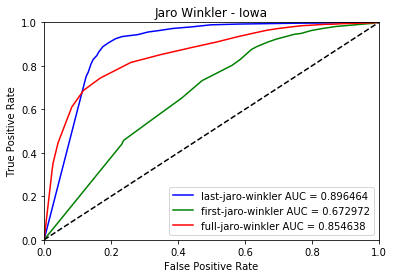

In [13]:
plot_roc(iowa, ['last-jaro-winkler', 'first-jaro-winkler','full-jaro-winkler'], title='Jaro Winkler - Iowa')

In [14]:
union['last-jaro-winkler'] = union.apply(lambda row: distance.get_jaro_distance(row.last1, row.last2), axis=1)
union['first-jaro-winkler'] = union.apply(lambda row: distance.get_jaro_distance(row.first1, row.first2), axis=1)
union['full-jaro-winkler'] = union.apply(lambda row: distance.get_jaro_distance(row.recname1, row.recname2), axis=1)

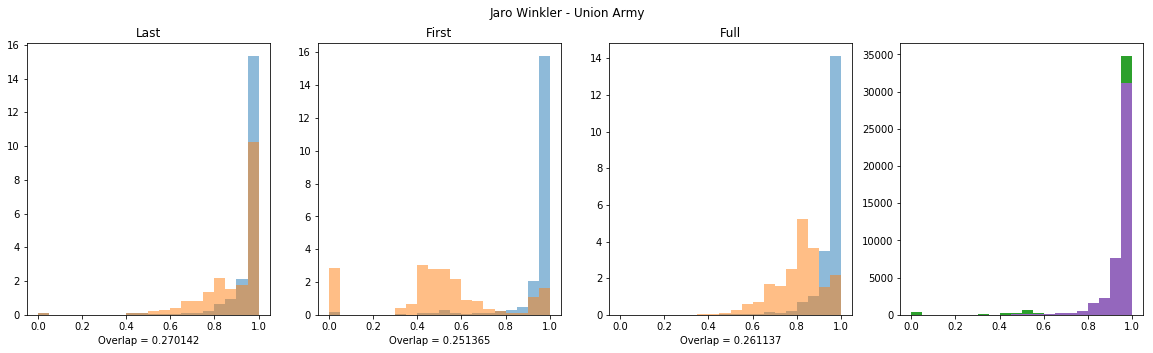

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Jaro Winkler - Union Army')
axes[0].hist(union[union['match'] == 1]['last-jaro-winkler'], alpha=.5,
             normed=True, bins=20)
axes[0].hist(union[union['match'] == 0]['last-jaro-winkler'], alpha=.5,
             normed=True, bins=20)
axes[0].set_title('Last')
axes[0].set_xlabel('Overlap = {:2f}'.format(
    hist_overlap(union[union['match'] == 1]['last-jaro-winkler'],
                 union[union['match'] == 0]['last-jaro-winkler'])))

axes[1].hist(union[union['match'] == 1]['first-jaro-winkler'], alpha=.5,
             normed=True, bins=20)
axes[1].hist(union[union['match'] == 0]['first-jaro-winkler'], alpha=.5,
             normed=True, bins=20)
axes[1].set_title('First')
axes[1].set_xlabel('Overlap = {:2f}'.format(
    hist_overlap(union[union['match'] == 1]['first-jaro-winkler'],
                 union[union['match'] == 0]['first-jaro-winkler'])))

axes[2].hist(union[union['match'] == 1]['full-jaro-winkler'], alpha=.5,
             normed=True, bins=20)
axes[2].hist(union[union['match'] == 0]['full-jaro-winkler'], alpha=.5,
             normed=True, bins=20)
axes[2].set_title('Full')
axes[2].set_xlabel('Overlap = {:2f}'.format(
    hist_overlap(union[union['match'] == 1]['full-jaro-winkler'],
                 union[union['match'] == 0]['full-jaro-winkler'])))


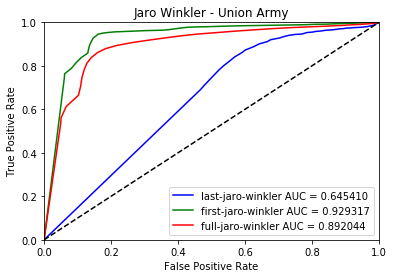

In [16]:
plot_roc(union, ['last-jaro-winkler', 'first-jaro-winkler','full-jaro-winkler'], title='Jaro Winkler - Union Army')

## Autoencoder Distance

#### Dense 

Loaded Model with input shape (None, 12)
Median mu has been set with size (2,)
Loaded Model with input shape (None, 12)
Median mu has been set with size (4,)
Loaded Model with input shape (None, 12)
Median mu has been set with size (8,)
Loaded Model with input shape (None, 12)
Median mu has been set with size (16,)
Loaded Model with input shape (None, 12)
Median mu has been set with size (24,)


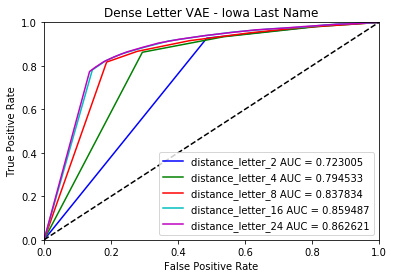

In [17]:
MAX_LENGTH = 12
EMBED_TYPE = 'letters'
dense_latent = [2, 4, 8, 16, 24]

iowa_trainA = embed(iowa['lname1915'],
                    max_length=MAX_LENGTH,
                    embed_type=EMBED_TYPE,
                    normalize=True)
iowa_trainB = embed(iowa['lname1940'],
                    max_length=MAX_LENGTH,
                    embed_type=EMBED_TYPE,
                    normalize=True)

cols = []
for latent in dense_latent:
    MODEL_PATH = '/Users/kailinlu/Desktop/QMSSWork/RecordLinking/models/dense_letter_{}_iowa_last/encoder.h5'.format(
        latent)

    dense_binary_encoder = BinaryEncoder(model_path=MODEL_PATH)
    dense_binary_encoder.calculate_median_mu(iowa_trainA)

    encodedA_iowa = dense_binary_encoder.encode(iowa_trainA)
    encodedB_iowa = dense_binary_encoder.encode(iowa_trainB)

    cols.append('distance_letter_{}'.format(latent))
    iowa['distance_letter_{}'.format(latent)] = normalized_l1(encodedA_iowa,
                                                              encodedB_iowa)

plot_roc(iowa, cols, title='Dense Letter VAE - Iowa Last Name')


Loaded Model with input shape (None, 12)
Median mu has been set with size (2,)
Loaded Model with input shape (None, 12)
Median mu has been set with size (4,)
Loaded Model with input shape (None, 12)
Median mu has been set with size (8,)
Loaded Model with input shape (None, 12)
Median mu has been set with size (16,)
Loaded Model with input shape (None, 12)
Median mu has been set with size (24,)


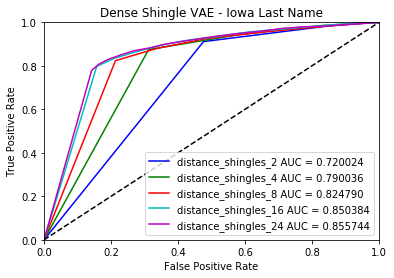

In [19]:
EMBED_TYPE = 'shingles'

iowa_trainA = embed(iowa['lname1915'],
                    max_length=MAX_LENGTH,
                    embed_type=EMBED_TYPE,
                    normalize=True)
iowa_trainB = embed(iowa['lname1940'],
                    max_length=MAX_LENGTH,
                    embed_type=EMBED_TYPE,
                    normalize=True)

shingle_cols = []
for latent in dense_latent:
    MODEL_PATH = '/Users/kailinlu/Desktop/QMSSWork/RecordLinking/models/dense_shingle_{}_iowa_last/encoder.h5'.format(
        latent)

    dense_binary_encoder = BinaryEncoder(model_path=MODEL_PATH)
    dense_binary_encoder.calculate_median_mu(iowa_trainA)

    encodedA_iowa = dense_binary_encoder.encode(iowa_trainA)
    encodedB_iowa = dense_binary_encoder.encode(iowa_trainB)

    shingle_cols.append('distance_shingles_{}'.format(latent))
    iowa['distance_shingles_{}'.format(latent)] = normalized_l1(encodedA_iowa,
                                                                encodedB_iowa)

plot_roc(iowa, shingle_cols, title='Dense Shingle VAE - Iowa Last Name')


Loaded Model with input shape (None, 12)
Median mu has been set with size (2,)
Loaded Model with input shape (None, 12)
Median mu has been set with size (4,)
Loaded Model with input shape (None, 12)
Median mu has been set with size (8,)
Loaded Model with input shape (None, 12)
Median mu has been set with size (16,)
Loaded Model with input shape (None, 12)
Median mu has been set with size (24,)


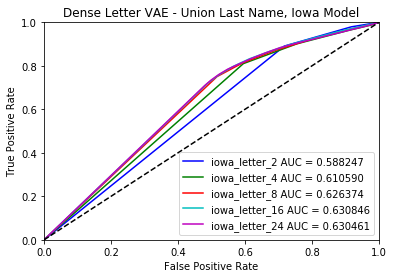

In [21]:
# Try model on union army last names - trained only on iowa last names 
MAX_LENGTH = 12
EMBED_TYPE = 'letters'
dense_latent = [2, 4, 8, 16, 24]

union_trainA = embed(union['last1'],
                     max_length=MAX_LENGTH,
                     embed_type=EMBED_TYPE,
                     normalize=True)
union_trainB = embed(union['last2'],
                     max_length=MAX_LENGTH,
                     embed_type=EMBED_TYPE,
                     normalize=True)

union_cols = []
for latent in dense_latent:
    MODEL_PATH = '/Users/kailinlu/Desktop/QMSSWork/RecordLinking/models/dense_letter_{}_iowa_last/encoder.h5'.format(
        latent)

    dense_binary_encoder = BinaryEncoder(model_path=MODEL_PATH)
    dense_binary_encoder.calculate_median_mu(union_trainA)

    encodedA_union = dense_binary_encoder.encode(union_trainA)
    encodedB_union = dense_binary_encoder.encode(union_trainB)

    union_cols.append('iowa_letter_{}'.format(latent))
    union['iowa_letter_{}'.format(latent)] = normalized_l1(encodedA_union,
                                                           encodedB_union)

plot_roc(union, union_cols,
         title='Dense Letter VAE - Union Last Name, Iowa Model')


Loaded Model with input shape (None, 12)
Median mu has been set with size (2,)
Loaded Model with input shape (None, 12)
Median mu has been set with size (4,)
Loaded Model with input shape (None, 12)
Median mu has been set with size (8,)
Loaded Model with input shape (None, 12)
Median mu has been set with size (16,)
Loaded Model with input shape (None, 12)
Median mu has been set with size (24,)


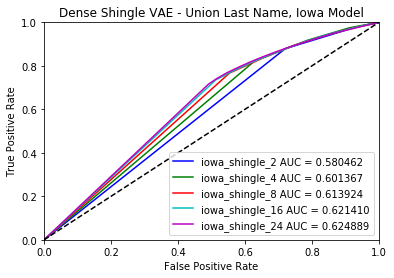

In [22]:
MAX_LENGTH = 12
EMBED_TYPE = 'shingles'
dense_latent = [2, 4, 8, 16, 24]

union_trainA = embed(union['last1'],
                     max_length=MAX_LENGTH,
                     embed_type=EMBED_TYPE,
                     normalize=True)
union_trainB = embed(union['last2'],
                     max_length=MAX_LENGTH,
                     embed_type=EMBED_TYPE,
                     normalize=True)

union_shingle_cols = []
for latent in dense_latent:
    MODEL_PATH = '/Users/kailinlu/Desktop/QMSSWork/RecordLinking/models/dense_shingle_{}_iowa_last/encoder.h5'.format(
        latent)

    dense_binary_encoder = BinaryEncoder(model_path=MODEL_PATH)
    dense_binary_encoder.calculate_median_mu(union_trainA)

    encodedA_union = dense_binary_encoder.encode(union_trainA)
    encodedB_union = dense_binary_encoder.encode(union_trainB)

    union_shingle_cols.append('iowa_shingle_{}'.format(latent))
    union['iowa_shingle_{}'.format(latent)] = normalized_l1(encodedA_union,
                                                            encodedB_union)

plot_roc(union, union_shingle_cols,
         title='Dense Shingle VAE - Union Last Name, Iowa Model')


Loaded Model with input shape (None, 12)
Median mu has been set with size (2,)
Loaded Model with input shape (None, 12)
Median mu has been set with size (4,)
Loaded Model with input shape (None, 12)
Median mu has been set with size (8,)
Loaded Model with input shape (None, 12)
Median mu has been set with size (16,)
Loaded Model with input shape (None, 12)
Median mu has been set with size (24,)


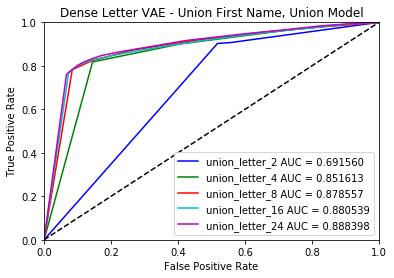

In [35]:
MAX_LENGTH = 12
EMBED_TYPE = 'letters'
dense_latent = [2, 4, 8, 16, 24]

union_trainA = embed(union['first1'],
                     max_length=MAX_LENGTH,
                     embed_type=EMBED_TYPE,
                     normalize=True)
union_trainB = embed(union['first2'],
                     max_length=MAX_LENGTH,
                     embed_type=EMBED_TYPE,
                     normalize=True)

union_cols = []
for latent in dense_latent:
    MODEL_PATH = '/Users/kailinlu/Desktop/QMSSWork/RecordLinking/models/dense_letter_{}_union_first/encoder.h5'.format(
        latent)

    dense_binary_encoder = BinaryEncoder(model_path=MODEL_PATH)
    dense_binary_encoder.calculate_median_mu(union_trainA)

    encodedA_union = dense_binary_encoder.encode(union_trainA)
    encodedB_union = dense_binary_encoder.encode(union_trainB)

    union_cols.append('union_letter_{}'.format(latent))
    union['union_letter_{}'.format(latent)] = normalized_l1(encodedA_union,
                                                            encodedB_union)

plot_roc(union, union_cols,
         title='Dense Letter VAE - Union First Name, Union Model')


#### LSTM 

Loaded Model with input shape (None, 12, 28)
Median mu has been set with size (2,)
Loaded Model with input shape (None, 12, 28)
Median mu has been set with size (4,)
Loaded Model with input shape (None, 12, 28)
Median mu has been set with size (8,)
Loaded Model with input shape (None, 12, 28)
Median mu has been set with size (16,)
Loaded Model with input shape (None, 12, 28)
Median mu has been set with size (24,)


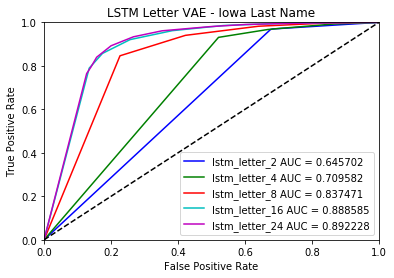

In [23]:
EMBED_TYPE = 'letters'

iowa_trainA = embed(iowa['lname1915'],
                    max_length=MAX_LENGTH,
                    embed_type=EMBED_TYPE,
                    normalize=False)
iowa_trainB = embed(iowa['lname1940'],
                    max_length=MAX_LENGTH,
                    embed_type=EMBED_TYPE,
                    normalize=False)
classes = 28
iowa_trainA = to_categorical(iowa_trainA, classes)
iowa_trainB = to_categorical(iowa_trainB, classes)

lstm_cols = []
for latent in dense_latent:
    MODEL_PATH = '/Users/kailinlu/Desktop/QMSSWork/RecordLinking/models/lstm_letter_{}_iowa_last/encoder.h5'.format(
        latent)

    dense_binary_encoder = BinaryEncoder(model_path=MODEL_PATH)
    dense_binary_encoder.calculate_median_mu(iowa_trainA)

    encodedA_iowa = dense_binary_encoder.encode(iowa_trainA)
    encodedB_iowa = dense_binary_encoder.encode(iowa_trainB)

    lstm_cols.append('lstm_letter_{}'.format(latent))
    iowa['lstm_letter_{}'.format(latent)] = normalized_l1(encodedA_iowa,
                                                          encodedB_iowa)

plot_roc(iowa, lstm_cols, title='LSTM Letter VAE - Iowa Last Name')


Loaded Model with input shape (None, 12, 28)
Median mu has been set with size (4,)
Loaded Model with input shape (None, 12, 28)
Median mu has been set with size (8,)
Loaded Model with input shape (None, 12, 28)
Median mu has been set with size (16,)
Loaded Model with input shape (None, 12, 28)
Median mu has been set with size (24,)


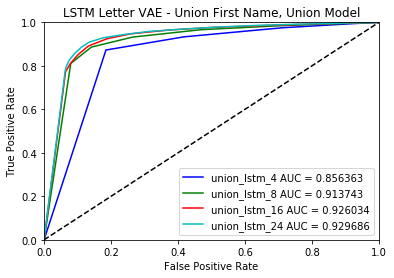

In [39]:
MAX_LENGTH = 12
EMBED_TYPE = 'letters'
dense_latent = [4, 8, 16, 24]

union_trainA = embed(union,
                     'first1',
                     max_length=MAX_LENGTH,
                     embed_type=EMBED_TYPE,
                     normalize=False,
                     categorical=True)
union_trainB = embed(union,
                     'first2',
                     max_length=MAX_LENGTH,
                     embed_type=EMBED_TYPE,
                     normalize=False,
                     categorical=True)

union_cols = []
for latent in dense_latent:
    MODEL_PATH = '/Users/kailinlu/Desktop/QMSSWork/RecordLinking/models/lstm_letter_{}_union_first/encoder.h5'.format(
        latent)

    dense_binary_encoder = BinaryEncoder(model_path=MODEL_PATH)
    dense_binary_encoder.calculate_median_mu(union_trainA)

    encodedA_union = dense_binary_encoder.encode(union_trainA)
    encodedB_union = dense_binary_encoder.encode(union_trainB)

    union_cols.append('union_lstm_{}'.format(latent))
    union['union_lstm_{}'.format(latent)] = normalized_l1(encodedA_union,
                                                          encodedB_union)

plot_roc(union, union_cols,
         title='LSTM Letter VAE - Union First Name, Union Model')


## Combination Distances: Mean of Rankings, Product of Rankings

### Iowa dataset

#### Mean ranking distance

In [24]:
# Rank JW score for last name 
iowa['last-jaro-winkler-rank'] = iowa[['last-jaro-winkler']].rank(ascending=True) / len(iowa)

In [25]:
for col in  ['distance_letter_2','distance_letter_4','distance_letter_8',
            'distance_letter_16', 'distance_letter_24',
             'distance_shingles_2','distance_shingles_4','distance_shingles_8', 
             'distance_shingles_16', 'distance_shingles_24', 
             'lstm_letter_2','lstm_letter_4','lstm_letter_8', 'lstm_letter_16', 'lstm_letter_24']:
    iowa[col +'_rank'] = iowa[[col]].rank(ascending=True) / len(iowa)

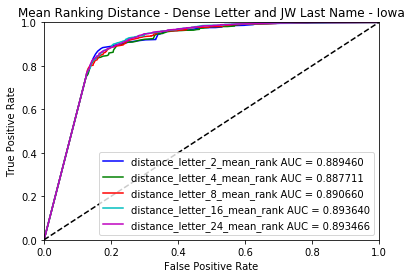

In [26]:
# Mean ranking 
mean_cols = [] 
for col in ['distance_letter_2','distance_letter_4','distance_letter_8',
            'distance_letter_16', 'distance_letter_24']:
    mean_cols.append(col + '_mean_rank')
    iowa[col + '_mean_rank'] = (iowa['last-jaro-winkler-rank'] + iowa[col+'_rank']) / 2. 

    
plot_roc(iowa, mean_cols, title='Mean Ranking Distance - Dense Letter and JW Last Name - Iowa')

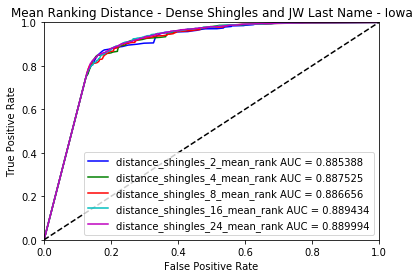

In [27]:
mean_cols = [] 
for col in ['distance_shingles_2','distance_shingles_4','distance_shingles_8',
            'distance_shingles_16', 'distance_shingles_24']:
    mean_cols.append(col + '_mean_rank')
    iowa[col + '_mean_rank'] = (iowa['last-jaro-winkler-rank'] + iowa[col+'_rank']) / 2. 

plot_roc(iowa, mean_cols, title='Mean Ranking Distance - Dense Shingles and JW Last Name - Iowa')

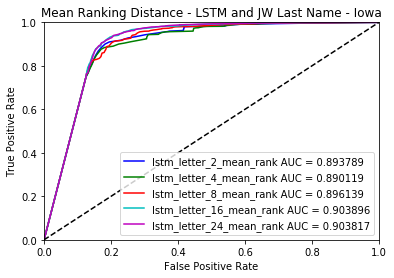

In [28]:
# Mean ranking 
mean_cols = [] 
for col in ['lstm_letter_2','lstm_letter_4','lstm_letter_8', 'lstm_letter_16', 'lstm_letter_24']:
    mean_cols.append(col + '_mean_rank')
    iowa[col + '_mean_rank'] = (iowa['last-jaro-winkler-rank'] + iowa[col+'_rank']) / 2. 
    
plot_roc(iowa, mean_cols, title='Mean Ranking Distance - LSTM and JW Last Name - Iowa')

#### Product ranking distance

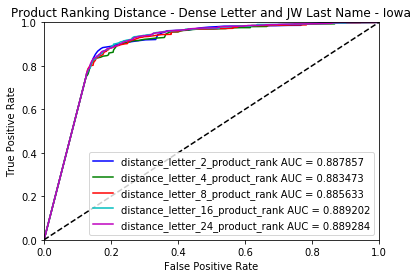

In [29]:
product_cols = [] 
for col in ['distance_letter_2','distance_letter_4','distance_letter_8',
            'distance_letter_16', 'distance_letter_24']:
    product_cols.append(col + '_product_rank')
    iowa[col + '_product_rank'] = 1 - (1 / (iowa['last-jaro-winkler-rank'] * iowa[col+'_rank']))

    
plot_roc(iowa, product_cols, title='Product Ranking Distance - Dense Letter and JW Last Name - Iowa')

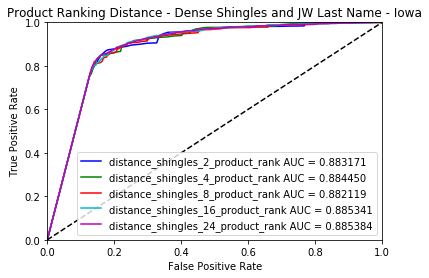

In [30]:
product_cols = [] 
for col in ['distance_shingles_2','distance_shingles_4','distance_shingles_8',
            'distance_shingles_16', 'distance_shingles_24']:
    product_cols.append(col + '_product_rank')
    iowa[col + '_product_rank'] = 1 - (1 / (iowa['last-jaro-winkler-rank'] * iowa[col+'_rank'])) 

plot_roc(iowa, product_cols, title='Product Ranking Distance - Dense Shingles and JW Last Name - Iowa')

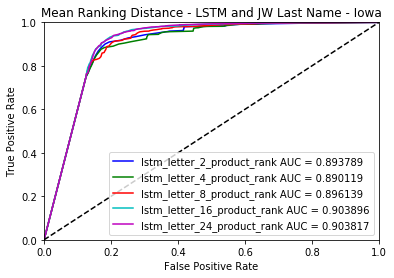

In [31]:
product_cols = [] 
for col in ['lstm_letter_2','lstm_letter_4','lstm_letter_8', 'lstm_letter_16', 'lstm_letter_24']:
    product_cols.append(col + '_product_rank')
    iowa[col + '_product_rank'] = (iowa['last-jaro-winkler-rank'] + iowa[col+'_rank']) / 2. 
    
plot_roc(iowa, product_cols, title='Mean Ranking Distance - LSTM and JW Last Name - Iowa')

### Union Army dataset

In [32]:
# Rank JW score for last name 
union['first-jaro-winkler-rank'] = union[['first-jaro-winkler']].rank(ascending=True) / len(union)

Loaded Model with input shape (None, 12)
Median mu has been set with size (4,)
Loaded Model with input shape (None, 12)
Median mu has been set with size (8,)
Loaded Model with input shape (None, 12)
Median mu has been set with size (16,)
Loaded Model with input shape (None, 12)
Median mu has been set with size (24,)


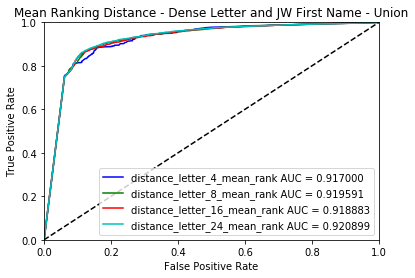

In [40]:
union_trainA = embed(union['first1'],
                     max_length=MAX_LENGTH,
                     embed_type=EMBED_TYPE,
                     normalize=True)
union_trainB = embed(union['first2'],
                     max_length=MAX_LENGTH,
                     embed_type=EMBED_TYPE,
                     normalize=True)

union_dense_cols = []
for latent in dense_latent:
    MODEL_PATH = '/Users/kailinlu/Desktop/QMSSWork/RecordLinking/models/dense_letter_{}_union_first/encoder.h5'.format(
        latent)

    dense_binary_encoder = BinaryEncoder(model_path=MODEL_PATH)
    dense_binary_encoder.calculate_median_mu(union_trainA)

    encodedA_union = dense_binary_encoder.encode(union_trainA)
    encodedB_union = dense_binary_encoder.encode(union_trainB)

    union_dense_cols.append('distance_letter_{}'.format(latent))
    union['distance_letter_{}'.format(latent)] = normalized_l1(encodedA_union,
                                                               encodedB_union)

for col in union_dense_cols:
    union[col + '_rank'] = union[[col]].rank(ascending=True) / len(union)

mean_cols = []
for col in union_dense_cols:
    mean_cols.append(col + '_mean_rank')
    union[col + '_mean_rank'] = (union['first-jaro-winkler-rank'] + union[
        col + '_rank']) / 2.

plot_roc(union, mean_cols,
         title='Mean Ranking Distance - Dense Letter and JW First Name - Union')


Loaded Model with input shape (None, 12, 28)
Median mu has been set with size (4,)
Loaded Model with input shape (None, 12, 28)
Median mu has been set with size (8,)
Loaded Model with input shape (None, 12, 28)
Median mu has been set with size (16,)
Loaded Model with input shape (None, 12, 28)
Median mu has been set with size (24,)


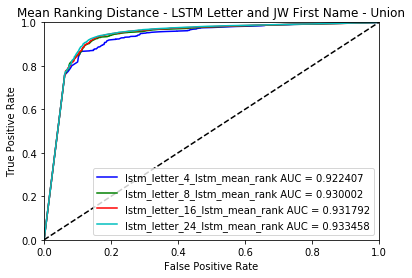

In [41]:
# Mean ranking - LSTM
union_trainA = embed(union['first1'],
                     max_length=MAX_LENGTH,
                     embed_type=EMBED_TYPE,
                   normalize=False,
                     categorical=True)
union_trainB = embed(union['first2'],
                     max_length=MAX_LENGTH,
                     embed_type=EMBED_TYPE,
                     normalize=False,
                     categorical=True)

union_dense_cols = []
dense_latent = [4, 8, 16, 24]
for latent in dense_latent:
    MODEL_PATH = '/Users/kailinlu/Desktop/QMSSWork/RecordLinking/models/lstm_letter_{}_union_first/encoder.h5'.format(
        latent)

    dense_binary_encoder = BinaryEncoder(model_path=MODEL_PATH)
    dense_binary_encoder.calculate_median_mu(union_trainA)

    encodedA_union = dense_binary_encoder.encode(union_trainA)
    encodedB_union = dense_binary_encoder.encode(union_trainB)

    union_dense_cols.append('lstm_letter_{}'.format(latent))
    union['lstm_letter_{}'.format(latent)] = normalized_l1(encodedA_union,
                                                           encodedB_union)

for col in union_dense_cols:
    union[col + '_rank'] = union[[col]].rank(ascending=True) / len(union)

mean_cols = []
for col in union_dense_cols:
    mean_cols.append(col + '_lstm_mean_rank')
    union[col + '_lstm_mean_rank'] = (union['first-jaro-winkler-rank'] + union[
        col + '_rank']) / 2.

plot_roc(union, mean_cols,
         title='Mean Ranking Distance - LSTM Letter and JW First Name - Union')


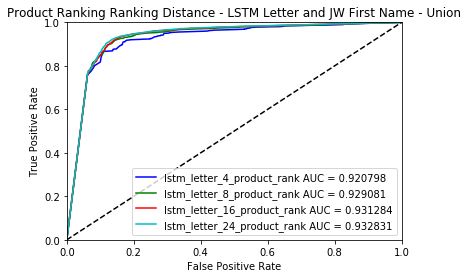

In [43]:
# Product ranking - Dense Letter
product_cols = [] 
for col in union_dense_cols:
    product_cols.append(col + '_product_rank')
    union[col + '_product_rank'] = 1 - (1 / (union['first-jaro-winkler-rank'] * union[col+'_rank']))
    
plot_roc(union, product_cols, title='Product Ranking Ranking Distance - LSTM Letter and JW First Name - Union')